# Assignment 1 - Decision Tree Classifiers

## Overview

This decision tree classifier is implemented as an extension of the [anytree](https://anytree.readthedocs.io/en/latest/index.html) module. By inheriting from the any tree node class, the tree structure is easily maintained and all custom code is simply added to the class.

Data manipulation is performed using [pandas](https://pandas.pydata.org/), which has many low-level functions built in to perform functions not directly related to the Decision Tree Classifier algorithms that are the focus of the assignment.

## Part 1: Splitting Algorithm

The splitting algorithm is implemented as follows

```
if stop criterion have not been met:
    compute the optimal split among all features and all split values of each feature
    split the samples into two subsamples based on this optimal split
    for each sample subset, apply the splitting algorithm
```

The stopping criterion, as specified, are that either the sample set is pure or all features of the set are identical. Pandas was used to quickly perform both of these checks. Purity was checked by looking at the number of unique labels within the set. Feature similarity was checked by ensuring that more than one sample still existed when duplicate features were removed

## Part 2: Pruning Algorithm

The pruning algorithm is implemented as follows:

```
Set the best observed accuracy to 0
At the root node:
    Make a list of all descendants of the node
    For each descendant:
        temporarily remove the node and its descendants
        calculate the accuracy of the new tree
        Add the node back into the tree
        if the new accuracy is greater than the current best accuracy:
            update best accuracy
            track the node that whose removal gave this accuracy
    Remove the best node (and its descendants) that gives the best resultant accuracy
```
Anytree makes this process very simple, since many of these steps simply involve changing a node's parent temporarily and then iterating over the new tree

## Part 3: Data Analysis

The follow code blocks contain the DCT implementation using pandas and anytree

In [1]:
#import pandas for dataset manipulation, anytree for tree visualization, and supporting modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os as os
import anytree as at
import anytree.exporter as texporter
import copy as copy

In [74]:
class DTCNode(at.Node):
    def __init__(self, name, samples, features,impurityType, resultVal, parent=None):
        self.name = name
        self.totalNodes = np.nan #hasn't been calculated yet
        self.totalLeafNodes = np.nan #hasn't been calculated yet
        self.parent = parent
        self.splitFeature = None
        self.splitValue = np.nan
        self.samples = samples
        self.trueSamples = None
        self.falseSamples = None
        self.features = features
        self.resultVal = resultVal
        self.label = self.computeLabel()
        self.impurityType = impurityType
        self.impurity = self.computeImpurity(self.samples)
        
        
        if not self.stopCriterionIsMet():
            [self.splitFeature, 
             self.splitValue,
             self.trueSamples,
             self.falseSamples,
             isLeaf] = self.computeOptimalSplit()
            
            if isLeaf: #this conditional is needed to due to what seems to be a numerical rounding error when a set
                       #is largely biased towards a single label, such as 180 0's and a single 1
                self.name = self.label
            else:
                self.name = self.name + "\n" + self.splitFeature + " <= " + str(self.splitValue)
                DTCNode("True", self.trueSamples, self.features, self.impurityType, True, parent=self)
                DTCNode("False", self.falseSamples, self.features, self.impurityType, False, parent=self)
        else:
            self.name = self.label
        if parent == None:
            self.countNodes()
            self.saveAsPNG(self.name)     
            
    def stopCriterionIsMet(self):
        return self.samplesArePure(self.samples) or self.sampleFeaturesAreIdentical(self.samples)
    
    # samples are pure if all the labels are the same
    # use pandas built-ins to do a bit of the heavy lifting
    # by counting the number of unique values within the label column,
    # if it is pure, there will only be a single unique value
    def samplesArePure(self, samples):
         return samples[samples.columns[0]].nunique() == 1
    
    # again use pandas built-ins for heavy lifting
    # by removing all rows with duplicate feature values. 
    # If all features are identical for all samples,
    # only one row will be remaining       
    def sampleFeaturesAreIdentical(self, samples):
        return len(samples.drop_duplicates(self.features).index) == 1
        
    # iterate through all features(and possible splits within those features)
    # in the node's samples and find the feature/split combo that minimizes the resultant
    # child node's weighted impurity.
    def computeOptimalSplit(self):
        bestImpurity = 1
        bestFeature = None
        bestValue = None
        bestTrueSubSample = None
        bestFalseSubSample = None
        #iterate through each feature
        for feature in self.features:
            #create an ordered list of values
            orderedValueList = self.samples[feature].sort_values(ascending=True).drop_duplicates()
            #create array of potential split values by averaging adjacent values in the list
            splitVals = []
            orderedValueList=orderedValueList.values
            for i in range(1,orderedValueList.size-1):
                
                #print(i)
                #print(orderedValueList[i-1])
                #print(orderedValueList[i])
                splitVals.append((orderedValueList[i]+orderedValueList[i-1])/2)
            for value in splitVals:
                [tempTrueSamples, tempFalseSamples] = self.split(feature, value)
                tempImpurity = self.computeWeightedImpurity(self.samples, 
                                                           tempTrueSamples,
                                                           tempFalseSamples)
                if tempImpurity < bestImpurity:
                    #print("Found a better split criterion!")
                    #print(bestFeature, bestValue)
                    bestImpurity = tempImpurity
                    bestFeature = feature;
                    bestValue = value
                    bestTrueSubSample = tempTrueSamples
                    bestFalseSubSample = tempFalseSamples
                    #print(bestTrueSubSample)
                    #print(bestFalseSubSample)
        return [bestFeature, bestValue, bestTrueSubSample, bestFalseSubSample, bestFeature==None]
        
    # returns two subsamples by splitting a node's samples based on a specified
    # feature and value
    # Uses pandas for heavy lifting
    def split(self, feature, value):
        # pandas supports boolean indexing, which makes this pretty trivial
        trueSubSamples = self.samples[self.samples[feature] <= value]
        falseSubSamples = self.samples[self.samples[feature] > value]
        return [trueSubSamples, falseSubSamples]
        
    def computeImpurity(self, samples):
        if self.impurityType == "Gini":
            return self.giniImpurity(samples)
        elif self.impurityType == "Entropy":
            return self.entropyImpurity(samples)
        else:
            raise ValueError("A valid impurity measure type was not specified!")
     
    # calculates the weighted impurity of a node's children
    # this function takes many shortcuts due to the assumptions
    # that it will only be computing the weighted impurity for 
    # a group of two nodes (the two children of a parent node)
    def computeWeightedImpurity(self, parentSamples, subSamples1, subSamples2):
        totalSamples = len(parentSamples.index)
        totalSubSamples1 = len(subSamples1.index)
        totalSubSamples2 = len(subSamples2.index)
        return ((totalSubSamples1/totalSamples)*self.computeImpurity(subSamples1) +
                (totalSubSamples2/totalSamples)*self.computeImpurity(subSamples2))
            
    # calculate the gini index of a set of samples  
    # this function takes many shortcuts due to the assumption 
    # that it will only be computing the gini index of binary data
    def giniImpurity(self, samples):
        #check if the sample set is pure
        if self.samplesArePure(samples):
            return 0
        #print(samples)
        value_counts = samples[samples.columns[0]].value_counts()
        labelOneCounts = value_counts[0]
        labelTwoCounts = value_counts[1]
        totalCounts = labelOneCounts + labelTwoCounts
        return 1 - np.square(labelOneCounts/totalCounts) - np.square(labelTwoCounts/totalCounts)
        
        
    # calculate the entropy of a set of samples
    # this function takes many shortcuts due to the assumption
    # that it will only be computing the gini index of binary data
    def entropyImpurity(self, samples):
        #check if the sample set is pure
        if self.samplesArePure(samples):
            return 0
        value_counts = samples[samples.columns[0]].value_counts()
        labelOneCounts = value_counts[0]
        labelTwoCounts = value_counts[1]
        totalCounts = labelOneCounts + labelTwoCounts
        return (-(labelOneCounts/totalCounts)*np.log2(labelOneCounts/totalCounts) - 
                (labelTwoCounts/totalCounts)*np.log2(labelTwoCounts/totalCounts))
    
    def computeLabel(self):
        # assign a label to the node that is the label
        # with the largest frequency within the nodes samples
        # value_counts returns frequency counts in descending order 
        # by default, so grab the index of the first one
        return self.samples[self.samples.columns[0]].value_counts().index[0]
        
    def classify(self, sample):
        if self.is_leaf:
            return self.label
        elif len(self.children) == 1:
            return self.children[0].classify(sample)
        else:
            
            if (sample[self.splitFeature].values[0] <= self.splitValue) == self.children[0].resultVal:
                return self.children[0].classify(sample)
            else:
                return self.children[1].classify(sample)
    
    # Classifies a dataset and generates stats using the provide actual labels
    # Returns classification accuracy and a dataframe with relevant classification stats
    def performClassification(self,samples, labels):
        results = []
        for i in range(0, len(samples.index)):
            results.append(self.classify(samples.iloc[[i]]))
        results = np.asarray(results)
        labels = np.asarray(labels)
        accurateResults = np.equal(results, labels)
        
        # true positives are when both the actual label and the result are of class 1
        truePositives = np.logical_and(results, labels)
        
        # true negative are when both the actual label and the result are of class 0
        # This is the NOR operator, which is broken into not(or) for numpy
        trueNegatives = np.logical_not(np.logical_or(results, labels))
        
        # false positives are when the actual label is class 0 and the result is class 1
        # this is XOR of results and labels ANDed with the results array
        falsePositives = np.logical_and(np.logical_xor(results, labels), results)
        
        # false negatives are when the actual label is class 1 and the result is class 0
        # this is XOR of results and labels ANDed with the labels array
        falseNegatives = np.logical_and(np.logical_xor(results, labels), labels)
        
        
        classificationDF = pd.DataFrame({'True Label': labels,
                                          'Classified Label': results,
                                          'Correct Classification': accurateResults.astype(int),
                                          'True Positive': truePositives.astype(int),
                                          'False Positive': falsePositives.astype(int),
                                          'True Negative': trueNegatives.astype(int),
                                          'False Negative': falseNegatives.astype(int)})
        return [np.sum(accurateResults)/len(samples.index), classificationDF]
    
    # removes the single best node from the tree that gives the best return possible
    # Along with modifying the tree, it returns the new accuracies based on training,
    # validation, and test data and a boolean stating whether a node was able to be removed 
    # (if there is only a root node, no pruning will be performed.)
    def pruneSingleGreedyNode(self,training,trainingLabels, validation, validationLabels, test, testLabels):
        if len(self.children) == 0:
            [trainingAccuracy, trainingDF] = self.performClassification(training, trainingLabels)
            [validationAccuracy, validationDF] = self.performClassification(validation, validationLabels)
            [testAccuracy, testDF] = self.performClassification(test, testLabels)
            return [self.totalLeafNodes, self.totalNodes,
                    trainingAccuracy, trainingDF,
                    validationAccuracy, validationDF,
                    testAccuracy, testDF,
                    True]
        bestValidationAccuracy = 0
        bestValidationDF = None
        bestNode = None
        for node in self.descendants:
            parent = node.parent
            node.parent = None
            [validationAccuracy, bestValidationDF] = self.performClassification(validation, validationLabels)
            node.parent = parent;
            if validationAccuracy > bestValidationAccuracy:
                bestValidationAccuracy = validationAccuracy
                validationDF = df
                bestNode = node
        bestNode.parent = None
        [trainingAccuracy, trainingDF] = self.performClassification(training, trainingLabels)
        [testAccuracy, testDF] = self.performClassification(test, testLabels)
        #update node count
        self.countNodes()
        singleton = self.totalNodes == 1
        return [self.totalLeafNodes, self.totalNodes,
                trainingAccuracy, trainingDF,
                bestValidationAccuracy, bestValidationDF,
                testAccuracy, testDF,
                singleton]
    
    #counts the number of leaf nodes and total number of nodes at this node's point and below in a tree
    def countNodes(self):
        self.totalLeafNodes = 0
        self.totalNodes = 1
        if self.is_leaf:
            self.totalLeafNodes = 1
        else:            
            for node in self.children:
                [numLeafs, numNodes] = node.countNodes()
                self.totalLeafNodes += numLeafs
                self.totalNodes += numNodes
        return [self.totalLeafNodes, self.totalNodes]
    
    # renders currrent tree using graphviz and saves it as a png
    def saveAsPNG(self, name):
        texporter.DotExporter(self).to_picture(name.strip() + '.png')
        
            

## Data Analysis Cont'd
The next step is to read in the datasets. The first run will use dataset_2, which contains the 80%/10%/10% split between Training/Validation/Testing data.

In [75]:
# Read in training dataset to be used
training = pd.read_csv('cancer_datasets_v2/training_2.csv')
#training.head()
trainingLabels = training[training.columns[0]]

In [76]:
# create a list of attributes for use later
# only need to do this once since all data has the same features
features = training.columns[1:]

In [77]:
# Read in validation dataset to be used
validation = pd.read_csv('cancer_datasets_v2/validation_2.csv')
#validation.head()
validationLabels = validation[validation.columns[0]]

In [78]:
# Read in test datasets to be used
test = pd.read_csv('cancer_datasets_v2/testing_2.csv')
#test.head()
testLabels = test[test.columns[0]]

## Data Analysis: Training

The following block trains the tree on this data, using the **Entropy** impurity measure.

In [79]:
# Train the tree
t2 = DTCNode("Dataset2", training, features, "Entropy",True, parent=None)

## Data Analysis: Training Results

The following code blocks provide the total number of nodes and leaf nodes as well as the classification accuracy on the training and testing data.

In [80]:
[totalLeafNodes, totalNodes] = t2.countNodes()
print("Total Nodes", totalNodes)
print("Total Leaf Nodes", totalLeafNodes)

Total Nodes 29
Total Leaf Nodes 15


In [81]:
[trainingAccuracy, trainingResultsDF] = t2.performClassification(training, trainingLabels)
[testAccuracy, testResultsDF] = t2.performClassification(test, testLabels)
print("Training Accuracy: ", trainingAccuracy)
print("Test Accuracy: ", testAccuracy)

Training Accuracy:  0.9978021978021978
Test Accuracy:  0.8771929824561403


In [82]:
t2.saveAsPNG('UnprunedDataset2')

## Data Analysis: Training with other dataset
The same analsysis is performed with dataset_1, which contains the 70%/10%/20% split between Training/Validation/Testing data

In [83]:
# Read in training dataset to be used
training = pd.read_csv('cancer_datasets_v2/training_1.csv')
#training.head()
trainingLabels = training[training.columns[0]]

In [84]:
# create a list of attributes for use later
# only need to do this once since all data has the same features
features = training.columns[1:]

In [85]:
# Read in validation dataset to be used
validation = pd.read_csv('cancer_datasets_v2/validation_1.csv')
#validation.head()
validationLabels = validation[validation.columns[0]]

In [86]:
# Read in test datasets to be used
test = pd.read_csv('cancer_datasets_v2/testing_1.csv')
#test.head()
testLabels = test[test.columns[0]]

In [87]:
# Train the tree
t1 = DTCNode("Dataset1", training, features, "Entropy",True, parent=None)

In [88]:
print("Total Nodes", t1.totalNodes)
print("Total Leaf Nodes", t1.totalLeafNodes)

Total Nodes 33
Total Leaf Nodes 17


In [89]:
[trainingAccuracy, trainingResultsDF] = t1.performClassification(training, trainingLabels)
[testAccuracy, testResultsDF] = t1.performClassification(test, testLabels)
print("Training Accuracy: ", trainingAccuracy)
print("Test Accuracy: ", testAccuracy)

Training Accuracy:  1.0
Test Accuracy:  0.9298245614035088


In [92]:
trainingResultsDF.describe()

,True Label,Classified Label,Correct Classification,True Positive,False Positive,True Negative,False Negative
count,398.000000,398.000000,398.0,398.000000,398.0,398.000000,398.0
mean,0.429648,0.429648,1.0,0.429648,0.0,0.570352,0.0
std,0.495649,0.495649,0.0,0.495649,0.0,0.495649,0.0
min,0.000000,0.000000,1.0,0.000000,0.0,0.000000,0.0
25%,0.000000,0.000000,1.0,0.000000,0.0,0.000000,0.0
50%,0.000000,0.000000,1.0,0.000000,0.0,1.000000,0.0
75%,1.000000,1.000000,1.0,1.000000,0.0,1.000000,0.0
max,1.000000,1.000000,1.0,1.000000,0.0,1.000000,0.0


In [90]:
t1.saveAsPNG('UnprunedDataset1')

## Data Analysis: Dataset Comparison

As can be seen, dataset 1 has a higher initial accuracy, for both testing and training data. On the other hand, dataset 2, which consists of a larger percentage of training data, has slightly few nodes in this unpruned state.
It is also interesting to note the completely different set of features and split values that appear between both trees.

The tree trained on **Dataset 1** has the following feature split strucuture:

![UnprunedDataset1](UnprunedDataset1.png)

The tree trained on **Dataset 2** has the following feature split structure:

![UnprunedDataset2](UnprunedDataset2.png)

These pictures will also be submitted separately to easier viewing

## Data Analysis: Pruning


In [96]:
t1Copy = copy.deepcopy(t1)
initialLeafNodes = t1Copy.totalLeafNodes
initialNodes = t1Copy.totalNodes
[initialTrainingAcc, initialTrainingDF] = t1Copy.performClassification(training, trainingLabels)
[initialValidationAcc, initialValidationDF] = t1Copy.performClassification(validation, validationLabels)
[initialTestAcc, df] = t1Copy.performClassification(test, testLabels)
initialFPRate = df['False Positive'].sum() / (df['False Positive'].sum() + df['True Negative'].sum())
initialTPRate = df['True Positive'].sum() / (df['True Positive'].sum() + df['False Negative'].sum())
initialPrecision = df['True Positive'].sum() / (df['True Positive'].sum() + df['False Positive'].sum())
initialRecall = initialTPRate
pruningData = [[initialLeafNodes,
               initialNodes,
               initialTrainingAcc,
               initialValidationAcc,
               initialTestAcc,
               initialFPRate,
               initialTPRate,
               initialPrecision,
               initialRecall
               ]]
pr = t1Copy.pruneSingleGreedyNode(training, trainingLabels,
                                              validation, validationLabels,
                                              test, testLabels)
while(not pr[8]):
    prunedLeafNodes = pr[0]
    prunedNodes = pr[1]
    prunedTrainingAcc = pr[2]
    prunedValidationAcc = pr[4]
    prunedTestAcc = pr[6]
    df = pr[7]
    prunedFPRate = df['False Positive'].sum() / (df['False Positive'].sum() + df['True Negative'].sum())
    prunedTPRate = df['True Positive'].sum() / (df['True Positive'].sum() + df['False Negative'].sum())
    prunedPrecision = df['True Positive'].sum() / (df['True Positive'].sum() + df['False Positive'].sum())
    prunedRecall = prunedTPRate
    
    
    pruningData.append([prunedLeafNodes,
                        prunedNodes,
                        prunedTrainingAcc,
                        prunedValidationAcc,
                        prunedTestAcc,
                        prunedFPRate,
                        prunedTPRate,
                        prunedPrecision,
                        prunedRecall])
    pr = t1Copy.pruneSingleGreedyNode(training, trainingLabels,
                                              validation, validationLabels,
                                              test, testLabels)
    
# convert array to pandas dataframe for easier visualization   
pruningDF = pd.DataFrame(pruningData, columns=['Number of Leaf Nodes',
                                               'Number of Nodes',
                                               'Training Accuracy',
                                               'Validation Accuracy',
                                               'Test Accuracy',
                                               'FP Rate',
                                               'TP Rate',
                                               'Precision',
                                               'Recall'])
pruningDF.describe()

/home/jeb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in long_scalars


,Number of Leaf Nodes,Number of Nodes,Training Accuracy,Validation Accuracy,Test Accuracy,FP Rate,TP Rate,Precision,Recall
count,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,12.000000,13.000000
mean,7.846154,16.000000,0.855624,0.993252,0.853576,0.043077,0.654832,0.895296,0.654832
std,5.273300,10.336021,0.096375,0.011411,0.064200,0.031342,0.217978,0.063817,0.217978
min,1.000000,2.000000,0.570352,0.964912,0.657895,0.000000,0.000000,0.818182,0.000000
25%,4.000000,8.000000,0.846734,0.982456,0.842105,0.026667,0.692308,0.849894,0.692308
50%,5.000000,11.000000,0.849246,1.000000,0.868421,0.040000,0.692308,0.889394,0.692308
75%,12.000000,24.000000,0.896985,1.000000,0.877193,0.080000,0.743590,0.935484,0.743590
max,17.000000,33.000000,1.000000,1.000000,0.929825,0.080000,0.948718,1.000000,0.948718


In [97]:
pruningDF.head(14)

,Number of Leaf Nodes,Number of Nodes,Training Accuracy,Validation Accuracy,Test Accuracy,FP Rate,TP Rate,Precision,Recall
0,17,33,1.000000,0.982456,0.929825,0.080000,0.948718,0.860465,0.948718
1,16,32,0.904523,1.000000,0.842105,0.080000,0.692308,0.818182,0.692308
2,12,25,0.896985,1.000000,0.842105,0.080000,0.692308,0.818182,0.692308
3,12,24,0.896985,1.000000,0.842105,0.080000,0.692308,0.818182,0.692308
4,10,21,0.891960,1.000000,0.868421,0.040000,0.692308,0.900000,0.692308
5,10,20,0.891960,1.000000,0.868421,0.040000,0.692308,0.900000,0.692308
6,5,11,0.849246,1.000000,0.877193,0.053333,0.743590,0.878788,0.743590
7,5,10,0.849246,1.000000,0.877193,0.053333,0.743590,0.878788,0.743590
8,4,9,0.846734,1.000000,0.894737,0.026667,0.743590,0.935484,0.743590
9,4,8,0.846734,1.000000,0.894737,0.026667,0.743590,0.935484,0.743590


# Accuracy Plots
Based on this data, the most accurate tree is the initial unpruned tree. Ignoring that outlier though, the test plot shows that accuracy does increase when pruning initial nodes from the tree, indicating that overfitting is occuring. THere is a marked dropoff in accuracy when the tree is pruned too far

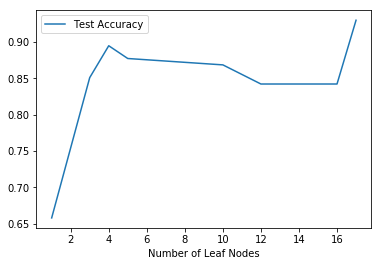

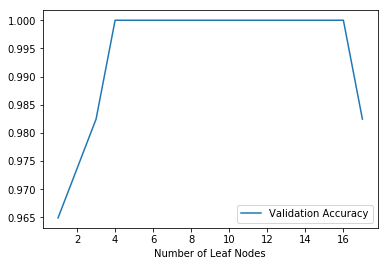

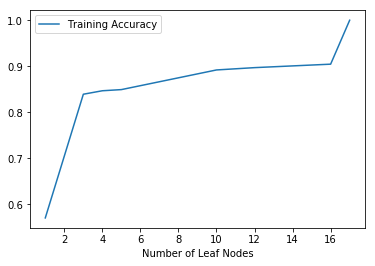

In [102]:
pruningDF.plot(x='Number of Leaf Nodes', y='Test Accuracy')
pruningDF.plot(x='Number of Leaf Nodes', y='Validation Accuracy')
pruningDF.plot(x='Number of Leaf Nodes', y='Training Accuracy')

# ROC and Precision-Recall Plots for Test Data
As can be see, there are some erors in these plots, so not very much information could be gleaned from them.

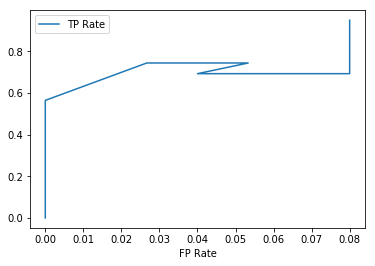

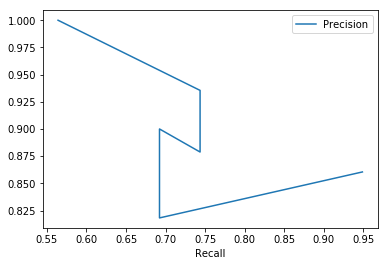

In [103]:
# ROC plot
pruningDF.plot(x='FP Rate', y = 'TP Rate')

# Precision-Recall Plot
pruningDF.plot(x='Recall', y='Precision')

## Tree Visualization
The following figure is a graphical representation of a tree trained on **dataset 1** and using **Entropy** as the impurity measure.  When viewing the tree, the **True/False** values at the top of each node represent the result of evaluating its parents feature split. The feature split of each node is then listed.

Note that due to the limitations of anytree's utilization of graphviz, all nodes with the same name are treated as a single node. Hence, the visualization only shows two leaf nodes named with the two possible labels, when in fact each arrow pointing to the leaf node is actually a distinct node. This is verified by the count metrics implemented in the code to determine the total number of nodes and leaf nodes (see above)

![TreeViz](TreeViz.png)

This picture will also be submitted separately.